# Bike Sharing Demand

**Problem statement**

A US bike-sharing provider **BoomBikes** wants to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:
- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands

Based on various meteorological surveys and people's styles, the service provider firm has gathered a large dataset on daily bike demands across the American market based on some factors. 

**Business goal**

You are required to model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market.

For this analysis, let's first import the Python libraries that will be used and define useful functions.

In [1]:
import sys
print('Python version: ', sys.version)

import pandas as pd              # Data manipulation tool
print('Pandas version: ',pd.__version__)
import seaborn as sns            # Data visualisation library
print('Seaborn version: ',sns.__version__)
import matplotlib
import matplotlib.pyplot as plt  # Data visualisation libray
print('Matplotlib version: ',matplotlib.__version__)
%matplotlib inline
import scipy
from scipy import stats
print('scipy version: ',scipy.__version__)

# Datetime manipulation
import datetime

# Model training library Sci-kit Learn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
print('SKLearn version: ',sklearn.__version__)

# Model training library statsmodels
import statsmodels.api as sm
print('statsmodels version: ',sm.__version__)

import warnings
warnings.filterwarnings('ignore') # Ignore warning messages

Python version:  3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Pandas version:  1.3.4
Seaborn version:  0.11.2
Matplotlib version:  3.4.3
scipy version:  1.7.1
SKLearn version:  0.24.2
statsmodels version:  0.12.2


Following function definition returns the month name given the month number.

In [2]:
def get_month_number(month_num):
    datetime_object = datetime.datetime.strptime(str(month_num), "%m")
    month_name = datetime_object.strftime("%b")
    return month_name.lower()

Following function definition creates a linear regression model with statsmodel library.

In [3]:
def sm_lr_model(X_train):
    #Add constant
    X_train_sm = sm.add_constant(X_train)

    # create a fitted model
    lm = sm.OLS(y_train,X_train_sm).fit()
    return lm

Following function calculates the VIF for a given dataset X

In [4]:
def get_vif(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by='VIF', ascending = False)
    return vif

## Data cleaning and manipulation

Let's read the file "day.csv" which contains the data we need, and store it in a variable called "df" (for dataframe):

In [5]:
df = pd.read_csv('day.csv')

The function info() will let us see at first glance the composition of the data:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


We have <b>16 columns</b> and <b>730 records</b>.

Do we really need 16 columns for the analysis? Let's <b>review</b> what kind of data they hold and check <b>whether we can narrow down</b> the amount of columns we'll work with by:

1. Filtering columns by missing values
2. Filtering single-value columns
3. Understanding each column (variable) description to check if it fits in analisys

### Missing values by column
Let's print the columns that hold null values.

In [7]:
# Get count of missing values, convert result to dataframe for aesthetic reasons
df_null = df.isna().sum().to_frame() 

# Rename aggregated column to "null_count"
df_null.columns = ['null_count']

df_null[df_null['null_count']>0]

,null_count


We can see that there are no columns with null values, **we won't drop any of them based on this criteria**.

### Columns with a single value
Columns with a single value do not add information for the results as the variance is zero, situation that can cause errors or unexpected results. We'll remove this columns.

In [8]:
# Use the nunique pandas function to count number of distinct elements in specified axis
print('Columns with unique values: ',len((df.loc[:,df.apply(pd.Series.nunique) == 1]).columns))

Columns with unique values:  0


There are **no columns with unique values**.

### Column description
For the columns we'll review their description to decide if data it's meaningful for our objective.

According to data dictionary, following variables are not significant for our analysis, we will get rid of them:

- instant: record index. Unique value with no significance.
- dteday: date. We will use day of the week which is derived from dteday, and we already have year column.
- casual: count of casual users. This value is not available in model daily use.
- registered: count of registered users. This value is not available in model daily use.

In [9]:
# Drop columns instant, dteday, casual, registered and atemp
df.drop(['instant', 'dteday','casual','registered'], axis=1, inplace=True)

Variables *temp* and *atemp* sound like they can be highly correlated. Let's take a look at their correlation within each other and within column *cnt*.

In [10]:
# Create a dataframe with both columns only
temp_cols = df[['temp','atemp','cnt']]

#Print variables correlation
temp_cols.corr()

,temp,atemp,cnt
temp,1.000000,0.991696,0.627044
atemp,0.991696,1.000000,0.630685
cnt,0.627044,0.630685,1.000000


We can see that *temp* and *atemp* columns are highly and positively correlated. "Feeling temperature" is a measure of how hot it really feels for a human when the relative humidity is factored in, so the high correlation would be an indicator of it being similar to actual temperature (i.e. both columns have similar values).

Also, both have almost same correlation with *cnt* variable. We will drop *atemp* column.

In [11]:
df.drop(['atemp'], axis=1, inplace=True)
print('df columns: ', len(df.columns))

df columns:  11


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   hum         730 non-null    float64
 9   windspeed   730 non-null    float64
 10  cnt         730 non-null    int64  
dtypes: float64(3), int64(8)
memory usage: 62.9 KB


After removing columns by description, **we have 11 columns**.

### Formatting columns
Following steps are part of this section:
1. Identifying categorical variables
2. Transforming categorical variables (where needed)

From data dictionary we have **identified following categorical variables**:

- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2018, 1:2019)
- mnth : month ( 1 to 12)
- holiday : weather day is a holiday or not
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit:
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    
Let's check how their values look like.

In [13]:
# Print columns unique values
print('season unique values: ',df['season'].unique())
print('yr unique values: ',df['yr'].unique())
print('mnth unique values: ',df['mnth'].unique())
print('holiday unique values: ',df['holiday'].unique())
print('weekday unique values: ',df['weekday'].unique())
print('workingday unique values: ',df['workingday'].unique())
print('weathersit unique values: ',df['weathersit'].unique())

season unique values:  [1 2 3 4]
yr unique values:  [0 1]
mnth unique values:  [ 1  2  3  4  5  6  7  8  9 10 11 12]
holiday unique values:  [0 1]
weekday unique values:  [6 0 1 2 3 4 5]
workingday unique values:  [0 1]
weathersit unique values:  [2 1 3]


Variables *yr*, *holiday*, and *workingday* already have binary values, we won't format them.

*season*, *mnth*, *weekday*, and *weathersit* have values that correspond to a category. For example, season value number 1 is for spring. We need a column named spring with binary values (0 and 1) to identify this, so before the dummy variables creation we'll map these columns' values to categories.

**Note for weekday**: week start in US is Sunday, so this value will be mapped to zero.

**Note for weathersit**: dataset does not contain 4 values but category for it will be defined.

**General note**: we will keep original numeric variables ("...num" colums) to easily plot them later.

In [14]:
# Create a dictionary to map seasons
seasons_dict = {1:'spring',2:'summer',3:'fall',4:'winter'}
# Map seasons column values
df['season'] = df['season'].map(seasons_dict)

# Get month name for month numbers
df['mnth_num'] = df['mnth']
df['mnth'] = df['mnth'].apply(lambda x: get_month_number(x))

# Create a dictionary to map weekdays
weekdays_dict = {0: 'sun', 1: 'mon', 2: 'tue', 3: 'wed', 4: 'thu', 5: 'fri', 6: 'sat'}
# Map weekday column values
df['weekday_num'] = df['weekday']
df['weekday'] = df['weekday'].map(weekdays_dict)

# Create a dictionary to map weathersit
weathersit_dict = {1:'clear_fewclouds',2:'mist_cloudy',3:'light_snowandrain',4:'heavyrain_icesnow'}
# Map weathersit column values
df['weathersit'] = df['weathersit'].map(weathersit_dict)

For all columns that contain values zero or one, let's assign the same data type *uint8*.

In [15]:
# Set type to uint8
df['yr'] = df['yr'].astype('uint8')
df['holiday'] = df['holiday'].astype('uint8')
df['workingday'] = df['workingday'].astype('uint8')

Now we have correctly defined categories for all categorical variables to map later in dummy variables.

In [16]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,mnth_num,weekday_num
0,spring,0,jan,0,sat,0,mist_cloudy,14.110847,80.5833,10.749882,985,1,6
1,spring,0,jan,0,sun,0,mist_cloudy,14.902598,69.6087,16.652113,801,1,0
2,spring,0,jan,0,mon,1,clear_fewclouds,8.050924,43.7273,16.636703,1349,1,1
3,spring,0,jan,0,tue,1,clear_fewclouds,8.200000,59.0435,10.739832,1562,1,2
4,spring,0,jan,0,wed,1,clear_fewclouds,9.305237,43.6957,12.522300,1600,1,3


## Data analysis

### Handling outliers

We'll create boxplots to check outliers better and determine if we should remove them based on their percentage.

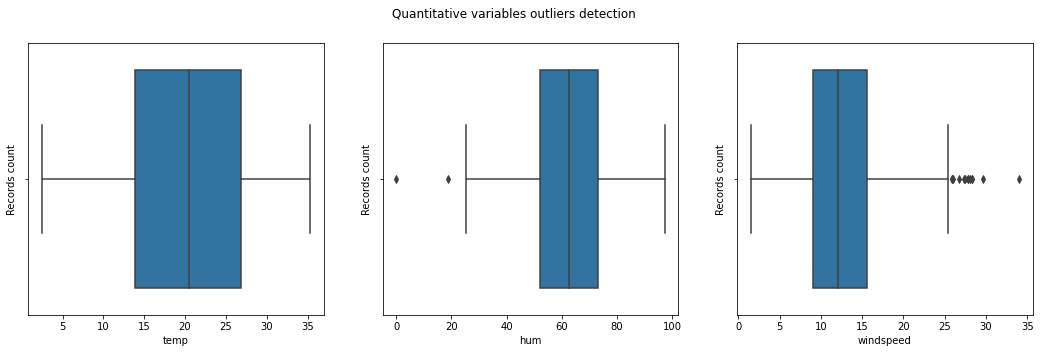

In [17]:
# Dataframe with quantitative variables only
df_quant = df[['temp','hum','windspeed']]

# To show two graphs
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Title for plots
fig.suptitle('Quantitative variables outliers detection')

# Create histograms
sns.boxplot(ax=ax[0], data=df_quant, x='temp')
sns.boxplot(ax=ax[1], data=df_quant, x='hum')
sns.boxplot(ax=ax[2], data=df_quant, x='windspeed')
ax[0].set(xlabel='temp', ylabel='Records count')
ax[1].set(xlabel='hum', ylabel='Records count')
ax[2].set(xlabel='windspeed', ylabel='Records count')
plt.show()

**For outliers in quantitative variables**, we see the variables distributions having a sort of "normal" distributions with few outliers at the tails:
- Right tail for hum
- Left tail for windspeed

In [18]:
# Computing IQR for hum
q1 = df_quant['hum'].quantile(0.25)
q3 = df_quant['hum'].quantile(0.75)
iqr = q3 - q1

# Computing lower fence
lower_fence = q1 - 1.5 * iqr

# Get values greater than upper fence for hum
gr_upper = df_quant[df_quant.hum<lower_fence].shape[0]
print('Values greater than upper fence for hum: ', gr_upper)
print('Percentage of total: ', round(gr_upper/df.shape[0]*100,2), '%')

# Computing IQR for windspeed
q1 = df_quant['windspeed'].quantile(0.25)
q3 = df_quant['windspeed'].quantile(0.75)
iqr = q3 - q1

# Computing upper fence
upper_fence = q3 + 1.5 * iqr

# Get values greater than upper fence for windspeed
gr_upper = df_quant[df_quant.windspeed>upper_fence].shape[0]
print('Values greater than upper fence for windspeed: ', gr_upper)
print('Percentage of total: ', round(gr_upper/df.shape[0]*100,2), '%')

Values greater than upper fence for hum:  2
Percentage of total:  0.27 %
Values greater than upper fence for windspeed:  13
Percentage of total:  1.78 %


We have less than 0.5% of outliers for *hum* and less than 2% for *windspeed*, which translates to ~2% of outliers.

**We won't drop outliers** as the amount is small and can be explained with weather behaviour not being 100% predictable.

### Categorical variables analysis

To review what we can infer about categorical variables effect on the dependent variable *cnt*, we will plot their total *cnt* (sum) by categories.

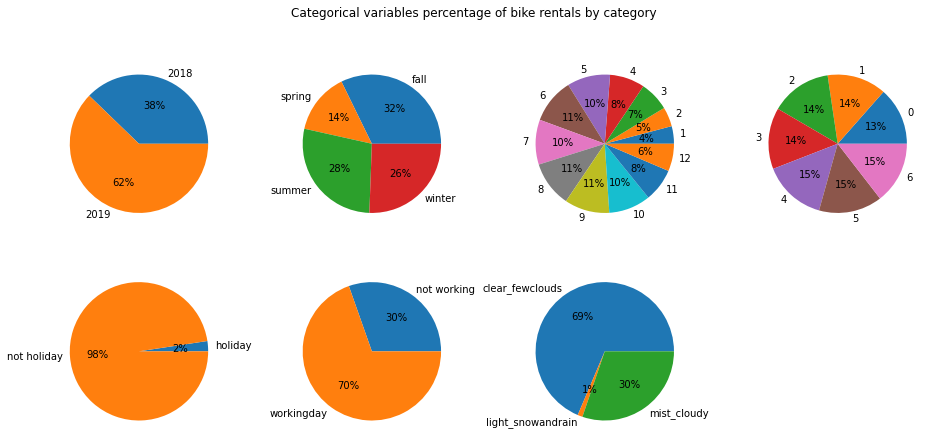

In [19]:
# Select quantitative variables
cat_vars = df[['yr','season','mnth_num','weekday_num','holiday','workingday','weathersit','cnt']]
cat_vars['yr'] = cat_vars['yr'].map({0:2018,1:2019})
cat_vars['holiday'] = cat_vars['holiday'].map({0:'not holiday',1:'holiday'})
cat_vars['workingday'] = cat_vars['workingday'].map({0:'not working',1:'workingday'})

# To show multiple graphs
fig, ax = plt.subplots(2, 4, figsize=(16, 7))

# Title for plots
fig.suptitle('Categorical variables percentage of bike rentals by category')

# Create histograms
r = 0
c = 0
for col in cat_vars.columns:
    if col != 'cnt':
        agg_tbl = pd.pivot_table(cat_vars, index=col, values='cnt', aggfunc='sum')
        ax[r,c].pie(agg_tbl['cnt'], labels = agg_tbl.index, autopct='%.0f%%')
        if r < 2 and c < 3:
            c += 1
        elif r < 2:
            r += 1
            c = 0
# Handle empty graph to show
fig.delaxes(ax[1,3])
plt.show()

From above pie charts we can see the percentage of total rental bikes (sum of *cnt*) by category for categorical columns. The **insights** we obtain are:
- Compared to 2018, **in 2019 bike rentals increased by 61.3%** (a considerable amount!).
- **Bike rentals are done the most in fall and summer**, and we can confirm that looking at the percentages by month (from 6 to 10).
- Percentage of bike rentals is similar for all days of the week.
- Almost all **bike rentals** (98%) were **done in days that did not correspond to a holiday**.
- A considerable percentage of **bike rentals** (70%) were **done in working days**.
- A considerable percentage of **bike rentals** (69%) were **done in clear with few clouds or partly cloudy days**.
    - There are no bike rentals on days with heavy rain, Ice Pallets, Thunderstorm and Mist, Snow and Fog. Company might not work on these days.

But looking into percentages is not enough, we want to review the categories distribution. For this we'll create boxplots to obtain more insights, confirm or deny the above ones.

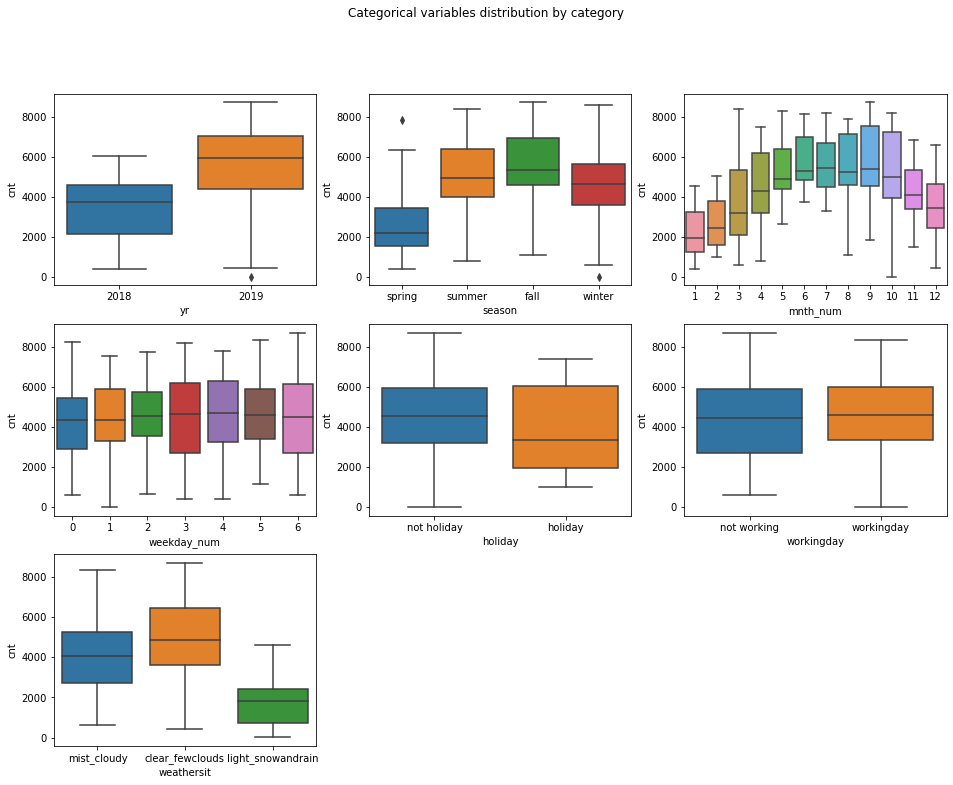

In [20]:
# To show multiple graphs
fig, ax = plt.subplots(3, 3, figsize=(16, 12))

# Title for plots
fig.suptitle('Categorical variables distribution by category')

# Create histograms
r = 0
c = 0
for col in cat_vars.columns:
    if col != 'cnt':
        sns.boxplot(ax=ax[r,c], x = col, y = 'cnt', data = cat_vars)
        if r < 3 and c < 2:
            c += 1
        elif r < 2:
            r += 1
            c = 0
# Handle empty graph to show
fig.delaxes(ax[2,1])
fig.delaxes(ax[2,2])
plt.show()

From above box plots we can see the distribution of bike rentals *cnt* by category. The **insights** we obtain are:
- Compared to 2018, **in 2019 bike rentals increased**. Median and around 50% of the data is clearly above the values for 2018, also we can detect low values as outliers (which translates to small amounts of bikes rental being rare).
- **Bike rentals are done the most in fall and summer**, and we can confirm that looking at the plots by month (from 6 to 10). 
    - Big amounts of bike rentals are rare during the spring (marked with the outliers).
- Distribution of bike rentals is similar for all days of the week.
- Range of bike rentals done in **days that did not correspond to a holiday** is bigger than in holidays, also with a higher median.
- Although we have a considerable percentage of bike rentals in working days, the **distribution in not working and in working days is similar** (both in median and range).
- A considerable amount of bike rentals were done **in clear with few clouds or partly cloudy days**. The difference in median is clear with the other two categories.
    - "Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds" days have significant less bikes rentals than the other two categories.

We observe that **following independent variables have a bigger effect on the bike rentals**, as the distributions by category differ the most:
- weathersit
- yr
- season
- mnth

### Numerical variables analysis
Let's create a pair plot to compare continuous quantitative variables behaviour and determine where we can find strong relationships (we already now there are some outliers).

Continuous quantitative variables are:
- temp
- hum
- windspeed

We will also include the target variable **cnt** to **check** from now **if there is any linear relationship we can use to justify using Linear Regression** to solve the business problem.

In [21]:
# Dataframe with quantitative variables only
df_quant = df[['temp','hum','windspeed','cnt']]

From below pairplot we see that for almost all continuous quantitative variables there is no clear trend (distribution), except for the **relationship between cnt and temp**. This relationship is clearly positive, and enough to <font color='light-blue'>**justify the use of Linear Regression**</font>.

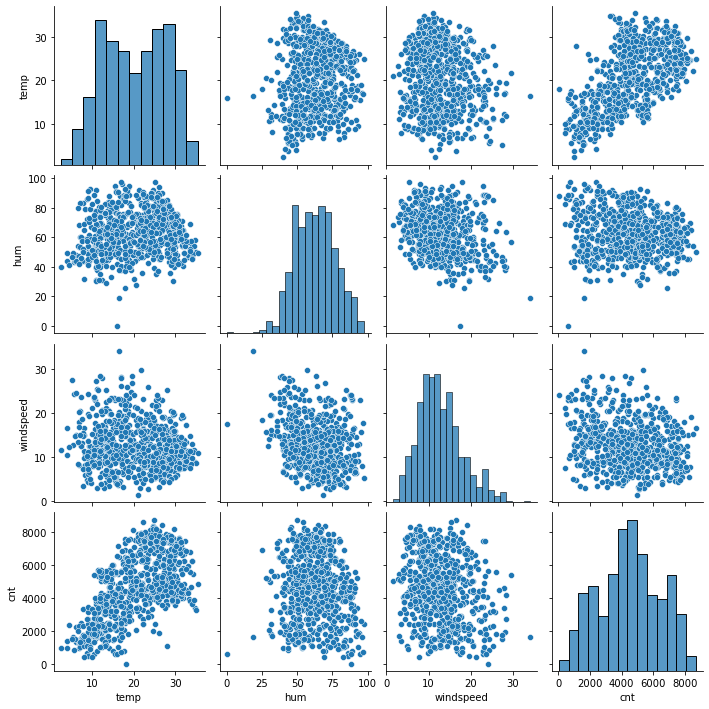

In [22]:
# Create pairplot
sns.pairplot(data=df_quant)
plt.show()

Also, from below heatmap we can see **the quantitative/numerical variables are not highly correlated between them**, might not be necessary to drop them in review of multicollinearity (coming in next sections).

- We can also see here that ***temp* and *cnt* have a high positive correlation** (0.63) compared to the others, and is telling us that the higher the temperature the more bikes are rented. It is expected to have *temp* in the final model to predict bikes rental.
- ***cnt* has a negative correlation with *hum* and *windspeed*** (-0.099 and -0.24), which would translate to the higher humidity and windspeed the more people don't renting bikes.

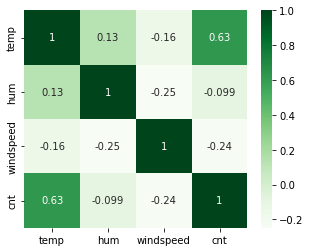

In [23]:
# Show numerical variables correlation
plt.figure(figsize = (5, 4))
sns.heatmap(df_quant.corr(), annot = True, cmap='Greens')
plt.show()

## Data preparation for modeling
Now we are ready to prepare the data for modeling. We'll drop useless columns and create dummy variables.

Let's first drop useless columns (columns we kept for categorical analysis).

In [24]:
# Drop useless columns for modeling
df.drop(['mnth_num','weekday_num'], axis=1, inplace=True)

Now we will create dummy variables for *season*, *mnth*, *weekday*, and *weathersit* columns.

In [25]:
# Create dummy variables
dummies = pd.get_dummies(df[['season','mnth','weekday','weathersit']], drop_first=True)

# Concat dummy variables to original dataframe df
df = pd.concat([df, dummies], axis = 1)

# Drop original source columns
df.drop(['season','mnth','weekday','weathersit'], axis=1, inplace=True)

Let's check the information of our dataframe df with recently added dummy columns.

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   yr                            730 non-null    uint8  
 1   holiday                       730 non-null    uint8  
 2   workingday                    730 non-null    uint8  
 3   temp                          730 non-null    float64
 4   hum                           730 non-null    float64
 5   windspeed                     730 non-null    float64
 6   cnt                           730 non-null    int64  
 7   season_spring                 730 non-null    uint8  
 8   season_summer                 730 non-null    uint8  
 9   season_winter                 730 non-null    uint8  
 10  mnth_aug                      730 non-null    uint8  
 11  mnth_dec                      730 non-null    uint8  
 12  mnth_feb                      730 non-null    uint8  
 13  mnth_

After the creation of dummies **we have 29 columns**. Let's take a look at first rows.

In [27]:
df.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_oct,mnth_sep,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_light_snowandrain,weathersit_mist_cloudy
0,0,0,0,14.110847,80.5833,10.749882,985,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0,0,0,14.902598,69.6087,16.652113,801,1,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,1,8.050924,43.7273,16.636703,1349,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,1,0,0,...,0,0,0,0,0,0,0,1,0,0


### Target variable simplification
To create the model we'll need to scale numerical variables, and all independent variables will have values between one and zero. The equation to predict *cnt* will have large coefficients as *cnt* values are big compared to the other variables.

What we can do **to simplify final analysis is divide *cnt* by 1000 so we have a user-friendly equation** (and we'll know that the actual predicted value will need to be multiplied by 1000).

In [28]:
df['cnt'] = df['cnt']/1000
df.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_oct,mnth_sep,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_light_snowandrain,weathersit_mist_cloudy
0,0,0,0,14.110847,80.5833,10.749882,0.985,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0,0,0,14.902598,69.6087,16.652113,0.801,1,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,1,8.050924,43.7273,16.636703,1.349,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.200000,59.0435,10.739832,1.562,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,9.305237,43.6957,12.522300,1.600,1,0,0,...,0,0,0,0,0,0,0,1,0,0


## Creating train and test sets
The first basic step for regression is performing a train-test split. For this we'll use SKLearn function *train_test_split*.

In [29]:
# We specify the random state so that the train and test data set always have the same rows count, respectively
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

# Prin the test and train dataframes shapes
print('Train set shape: ', df_train.shape)
print('Test set shape: ', df_test.shape)

Train set shape:  (510, 29)
Test set shape:  (219, 29)


### Rescaling the features
It is important to rescale the variables so that they have a comparable scale. Categorical variables have all values 0 or 1, while numerical ones don't and will need to be rescaled to a range between 0 and 1.

As we need a range between 0 and 1, we'll use *normalisation* (MinMax). Also, as we are keeping the outliers, this scaling method we'll help reduce their effect.

In [30]:
# Create an object for MinMax scaler
scaler = MinMaxScaler()

# Apply scaler() to the numerical columns
num_vars = ['temp', 'hum', 'windspeed']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

Now we have all **variables in same range** to apply linear regression.

In [31]:
# Describe numerical variables
df_train[['temp','hum','windspeed']].describe()

,temp,hum,windspeed
count,510.000000,510.000000,510.000000
mean,0.537262,0.650369,0.320768
std,0.225844,0.145882,0.169797
min,0.000000,0.000000,0.000000
25%,0.339853,0.538643,0.199179
50%,0.540519,0.653714,0.296763
75%,0.735215,0.754830,0.414447
max,1.000000,1.000000,1.000000


We'll print the variables correlations to have an idea of which variables we could use for the model.

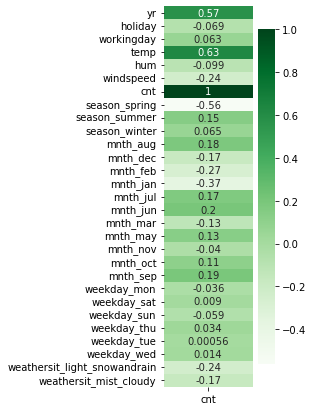

In [32]:
# Get correlation column only for cnt
df_corr = pd.DataFrame(df.corr()['cnt'],index=df.corr().index)

# Print variables correlation coefficients with cnt
plt.figure(figsize = (2, 7))
sns.heatmap(df_corr, annot = True, cmap='Greens')
plt.show()

When looking at the correlation value it might still not be clear if we should use a variable or not in the model, we need to check if the correlation coefficients are significant. For that, we can use *stats.pearsonr* method to **obtain the p-value for a correlation coefficient**.

If p-value is less than 0.05, we can say that the correlation coefficient is significant.

If p-value is greater than 0.05, there is inconclusive evidence about the significance.

In [33]:
# Get p-value for variables to check their significance (against cnt column)
print('significant p-values for variables (against cnt column)\n')
for col in df.columns:
    p_value = stats.pearsonr(df[col], df['cnt'])[1]
    if p_value < 0.05 and col != 'cnt':
        print('\'{0}\' p-value: {1}'.format(col, round(stats.pearsonr(df[col], df['cnt'])[1],4)))
        
# Get p-value for variables to check their significance (against cnt column)
print('\nnot significant p-values for variables (against cnt column)\n')
for col in df.columns:
    p_value = stats.pearsonr(df[col], df['cnt'])[1]
    if p_value > 0.05 and col != 'cnt':
        print('\'{0}\' p-value: {1}'.format(col, round(stats.pearsonr(df[col], df['cnt'])[1],4)))

significant p-values for variables (against cnt column)

'yr' p-value: 0.0
'temp' p-value: 0.0
'hum' p-value: 0.0077
'windspeed' p-value: 0.0
'season_spring' p-value: 0.0
'season_summer' p-value: 0.0001
'mnth_aug' p-value: 0.0
'mnth_dec' p-value: 0.0
'mnth_feb' p-value: 0.0
'mnth_jan' p-value: 0.0
'mnth_jul' p-value: 0.0
'mnth_jun' p-value: 0.0
'mnth_mar' p-value: 0.0005
'mnth_may' p-value: 0.0003
'mnth_oct' p-value: 0.0032
'mnth_sep' p-value: 0.0
'weathersit_light_snowandrain' p-value: 0.0
'weathersit_mist_cloudy' p-value: 0.0

not significant p-values for variables (against cnt column)

'holiday' p-value: 0.0633
'workingday' p-value: 0.0913
'season_winter' p-value: 0.081
'mnth_nov' p-value: 0.2763
'weekday_mon' p-value: 0.3315
'weekday_sat' p-value: 0.808
'weekday_sun' p-value: 0.1103
'weekday_thu' p-value: 0.3654
'weekday_tue' p-value: 0.988
'weekday_wed' p-value: 0.7055


From above categorical variables **were also spotted as relevant in the categorical variables analysis**, now we have specific categories that might be more relevant for the prediction.

As per reviewing *multicollinearity*, we'll check in the specific section.

### Dividing into X and Y sets for the model building
Now we'll separate the dependent variables from the independent one.

In [34]:
y_train = df_train.pop('cnt')
X_train = df_train

## Building the model
In previous section we got a list of variables and its correlation significance against *cnt*. There are in total 18 columns with a significant correlation coefficient, but as we want to narrow down the final number of variables we might want to start with a lower value.

We'll use Recursive Feature Elimination **(RFE)** and start with **number of variables equal to 15**. Then we can compare with previous results and start the modeling.

In [35]:
# Run RFE with the output number of variables equal to 18
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 15)             
rfe = rfe.fit(X_train, y_train)

In [36]:
# Print the variables with ranking obtained from RFE
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', True, 1),
 ('season_winter', True, 1),
 ('mnth_aug', False, 6),
 ('mnth_dec', False, 3),
 ('mnth_feb', False, 4),
 ('mnth_jan', True, 1),
 ('mnth_jul', True, 1),
 ('mnth_jun', False, 13),
 ('mnth_mar', False, 14),
 ('mnth_may', False, 5),
 ('mnth_nov', False, 2),
 ('mnth_oct', False, 10),
 ('mnth_sep', True, 1),
 ('weekday_mon', False, 8),
 ('weekday_sat', True, 1),
 ('weekday_sun', False, 7),
 ('weekday_thu', False, 11),
 ('weekday_tue', False, 9),
 ('weekday_wed', False, 12),
 ('weathersit_light_snowandrain', True, 1),
 ('weathersit_mist_cloudy', True, 1)]

In [37]:
# Print the columns selected by RFE
selected_cols = X_train.columns[rfe.support_]
print('Total selected columns by RFE: ',len(selected_cols))
selected_cols

Total selected columns by RFE:  15


Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'season_spring', 'season_summer', 'season_winter', 'mnth_jan',
       'mnth_jul', 'mnth_sep', 'weekday_sat', 'weathersit_light_snowandrain',
       'weathersit_mist_cloudy'],
      dtype='object')

In [38]:
# Print the columns not selected by RFE
print('Not selected columns by RFE')
X_train.columns[~rfe.support_]

Not selected columns by RFE


Index(['mnth_aug', 'mnth_dec', 'mnth_feb', 'mnth_jun', 'mnth_mar', 'mnth_may',
       'mnth_nov', 'mnth_oct', 'weekday_mon', 'weekday_sun', 'weekday_thu',
       'weekday_tue', 'weekday_wed'],
      dtype='object')

The **common columns** we have with our **previous review** (with correlation coefficients and p-value) are in total 11:
- yr
- temp
- hum
- windspeed
- season_spring
- season_summer
- mnth_jan
- mnth_jul
- mnth_sep
- weathersit_light_snowandrain
- weathersit_mist_cloudy

RFE selected this **different** 4 variables:
- holiday
- workingday
- season_winter
- weekday_sat

### First model

We'll go with a **first model using RFE selected columns**, as it has used most of the columns we have analysed before and confirmed are related to *cnt*.

We'll use statsmodel library to get detailed statistics. 

In [39]:
# Create an X_test dataframe with RFE selected variables
X_train_lm1 = X_train[selected_cols]

# Call function to generate model
lm_1 = sm_lr_model(X_train_lm1)

Let's see the **summary of our first linear model**.

In [40]:
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.6
Date:                Mon, 11 Apr 2022   Prob (F-statistic):          2.31e-191
Time:                        23:30:37   Log-Likelihood:                -582.94
No. Observations:                 510   AIC:                             1198.
Df Residuals:                     494   BIC:                             1266.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            2.2041      0.314      7.019      0.000       1.587       2.821
yr                               2.0035      0.070     28.807      0.000       1.867       2.140
holiday                         -0.5087      0.234     -2.178      0.030      -0.968      -0.050
workingday                       0.3783      0.100      3.781      0.000       0.182       0.575
temp                             4.4315      0.298     14.851      0.000       3.845       5.018
hum                             -1.3448      0.324     -4.145      0.000      -1.982      -0.707
windspeed                       -1.6163      0.221     -7.301      0.000      -2.051      -1.181
season_spring                   -0.4416      0.179     -2.461      0.014      -0.794      -0.089
season_summer                    0.4316      0.129      3.346      0.001       0.178       0.685
season_winter                    0.8208      0.150      5.479      0.000       0.526       1.115
mnth_jan                        -0.2984      0.151     -1.980      0.048      -0.594      -0.002
mnth_jul                        -0.4624      0.157     -2.947      0.003      -0.771      -0.154
mnth_sep                         0.7057      0.143      4.934      0.000       0.425       0.987
weekday_sat                      0.4669      0.126      3.707      0.000       0.219       0.714
weathersit_light_snowandrain    -2.1624      0.226     -9.560      0.000      -2.607      -1.718
weathersit_mist_cloudy          -0.5026      0.090     -5.574      0.000      -0.680      -0.325
==============================================================================
Omnibus:                       66.344   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              161.565
Skew:                          -0.676   Prob(JB):                     8.25e-36
Kurtosis:                       5.403   Cond. No.                         22.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Most relevant summary statistics**:
- $R^{2}$ = 0.849
- Adjusted $R^{2}$ = 0.844
- F-statistic = 184.6
- P(F-statistic) = 2.31e-191 ~ 0.0

$R^{2}$ and the Adjusted $R^{2}$ have similar values, which means **the model is significant**.

The value of the F-statistic is high and the Prob(F) is almost zero and hence, we can conclude that **the overall model fit is significant**. 

From the beginning we have had *weathersit*, *season*, *mnth*, *yr*, *temp*, and *hum* as relevant variables. These results make sense as bike rentals will be made in seasons with high temperature but with low humidity/rain/snow.

We do not have variables with a p-value greater than 0.05, but we cannot confirm the model is the best one we can obtain, **we also need to look at the Variance Inflation Factor (VIF)**.

In [41]:
# Calculate VIF for X_train
get_vif(X_train_lm1)

,Features,VIF
4,hum,29.40
3,temp,17.77
2,workingday,5.31
5,windspeed,4.73
6,season_spring,4.53
8,season_winter,3.48
7,season_summer,2.84
14,weathersit_mist_cloudy,2.29
0,yr,2.09
12,weekday_sat,1.98


As we can see, we have **3 variables with a high VIF** (greater than 5). First we'll drop one and then continue with the others.

### Second model

We'll start by dropping the variable with highest VIF value, *hum*, and then build a new model.

In [42]:
# Drop mnth_feb variable
X_train_lm2 = X_train_lm1.drop(['hum'],axis = 1)

# Call function to generate model
lm_2 = sm_lr_model(X_train_lm2)

Let's see the **summary of our second linear model**.

In [43]:
lm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     190.3
Date:                Mon, 11 Apr 2022   Prob (F-statistic):          7.33e-189
Time:                        23:30:37   Log-Likelihood:                -591.66
No. Observations:                 510   AIC:                             1213.
Df Residuals:                     495   BIC:                             1277.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            1.5315      0.273      5.605      0.000       0.995       2.068
yr                               2.0371      0.070     29.019      0.000       1.899       2.175
holiday                         -0.4885      0.237     -2.058      0.040      -0.955      -0.022
workingday                       0.4042      0.101      3.983      0.000       0.205       0.604
temp                             4.1098      0.293     14.037      0.000       3.535       4.685
windspeed                       -1.3583      0.216     -6.292      0.000      -1.782      -0.934
season_spring                   -0.5189      0.181     -2.861      0.004      -0.875      -0.163
season_summer                    0.3768      0.130      2.890      0.004       0.121       0.633
season_winter                    0.6927      0.149      4.650      0.000       0.400       0.985
mnth_jan                        -0.3385      0.153     -2.215      0.027      -0.639      -0.038
mnth_jul                        -0.4191      0.159     -2.635      0.009      -0.732      -0.107
mnth_sep                         0.6547      0.145      4.522      0.000       0.370       0.939
weekday_sat                      0.5079      0.128      3.980      0.000       0.257       0.759
weathersit_light_snowandrain    -2.5357      0.211    -12.027      0.000      -2.950      -2.121
weathersit_mist_cloudy          -0.7181      0.075     -9.592      0.000      -0.865      -0.571
==============================================================================
Omnibus:                       67.959   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.078
Skew:                          -0.690   Prob(JB):                     8.64e-37
Kurtosis:                       5.431   Cond. No.                         20.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Most relevant summary statistics**:
- $R^{2}$ = 0.843
- Adjusted $R^{2}$ = 0.839
- F-statistic = 190.3
- P(F-statistic) = 7.33e-189 ~ 0.0

After **removing *hum*** the $R^{2}$ and the Adjusted $R^{2}$ **values remained almost the same**, so we confirm the variable was not significant for the model.
$R^{2}$ and the Adjusted $R^{2}$ have similar values, which means **the model is still significant**.

The value of the F-statistic increased by removing *hum* and the Prob(F) decreased and hence, we can conclude that **the overall model fit is still significant**, and even more than last one.

During numerical variables analysis we saw a negative correlation between hum and cnt that was kept here: the higher hum, the less people renting bikes. Humidity is not significant, but we could say that the model is still keeping the humidity "inside" the season or month categories (as every season/month have specific humidity characteristics).

We can also see that general p-values decreased. But we still need to review **new VIF values**.

In [44]:
# Calculate VIF for X_train_lm2
get_vif(X_train_lm2)

,Features,VIF
3,temp,7.07
2,workingday,5.24
4,windspeed,4.67
5,season_spring,3.08
6,season_summer,2.33
0,yr,2.08
7,season_winter,1.99
11,weekday_sat,1.97
8,mnth_jan,1.62
9,mnth_jul,1.59


VIF values decreased, but still *temp* and *workingday* have high VIF values.

We have **2 variables with a high VIF** (greater than 5). First we'll drop one and then see if it is still necessary dropping the other.

### Third model

We'll start by dropping the variable with highest p-value, *temp*, and then build a new model.

In [45]:
# Drop mnth_feb variable
X_train_lm3 = X_train_lm2.drop(['temp'],axis = 1)

# Call function to generate model
lm_3 = sm_lr_model(X_train_lm3)

Let's see the **summary of our third linear model**.

In [46]:
lm_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     136.0
Date:                Mon, 11 Apr 2022   Prob (F-statistic):          4.04e-154
Time:                        23:30:37   Log-Likelihood:                -677.10
No. Observations:                 510   AIC:                             1382.
Df Residuals:                     496   BIC:                             1441.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            4.7575      0.175     27.262      0.000       4.415       5.100
yr                               2.1536      0.082     26.156      0.000       1.992       2.315
holiday                         -0.4964      0.280     -1.771      0.077      -1.047       0.054
workingday                       0.4174      0.120      3.482      0.001       0.182       0.653
windspeed                       -1.6326      0.254     -6.429      0.000      -2.132      -1.134
season_spring                   -2.2624      0.156    -14.490      0.000      -2.569      -1.956
season_summer                   -0.3825      0.140     -2.729      0.007      -0.658      -0.107
season_winter                   -0.6510      0.135     -4.829      0.000      -0.916      -0.386
mnth_jan                        -0.8905      0.174     -5.104      0.000      -1.233      -0.548
mnth_jul                        -0.0857      0.186     -0.461      0.645      -0.451       0.279
mnth_sep                         0.6158      0.171      3.601      0.000       0.280       0.952
weekday_sat                      0.4901      0.151      3.252      0.001       0.194       0.786
weathersit_light_snowandrain    -2.6463      0.249    -10.634      0.000      -3.135      -2.157
weathersit_mist_cloudy          -0.7790      0.088     -8.824      0.000      -0.952      -0.606
==============================================================================
Omnibus:                       34.622   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.832
Skew:                          -0.419   Prob(JB):                     3.07e-15
Kurtosis:                       4.563   Cond. No.                         11.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Most relevant summary statistics**:
- $R^{2}$ = 0.781
- Adjusted $R^{2}$ = 0.775
- F-statistic = 136
- P(F-statistic) = 4.04e-154 ~ 0.0

After **removing *temp*** the $R^{2}$ and the Adjusted $R^{2}$ **decreased significantly**, so we cannot confirm the variable was not significant for the model.
$R^{2}$ and the Adjusted $R^{2}$ have similar values, which means **the model is still significant**.

The value of the F-statistic decreased by removing *temp* and the Prob(F) is still almost zero, we can conclude that **the overall model fit is still significant**, but less significant than the last one.

By dropping the variable *temp*, **two other variables significantly increased their p-value**, *holiday* and *mnth_jul*, making them considerably greater than 0.05.

Let's review **new VIF values**.

In [47]:
# Calculate VIF for X_train_lm3
get_vif(X_train_lm3)

,Features,VIF
3,windspeed,4.27
2,workingday,3.83
4,season_spring,2.97
5,season_summer,2.27
6,season_winter,1.99
0,yr,1.91
10,weekday_sat,1.69
7,mnth_jan,1.60
12,weathersit_mist_cloudy,1.56
8,mnth_jul,1.30


VIF values decreased, having **all now smaller than 5**. 

But as per the high p-values, we can say that **dropping *temp* variable was not a good decision** so we'll stay so far with second model.

### Fourth model

We'll start from second model, by dropping the variable with highest VIF that is not *temp*, *workingday*, and then build a new model.

In [48]:
# Drop mnth_feb variable
X_train_lm4 = X_train_lm2.drop(['workingday'],axis = 1)

# Call function to generate model
lm_4 = sm_lr_model(X_train_lm4)

Let's see the **summary of our fourth linear model**.

In [49]:
lm_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     197.8
Date:                Mon, 11 Apr 2022   Prob (F-statistic):          1.21e-186
Time:                        23:30:37   Log-Likelihood:                -599.71
No. Observations:                 510   AIC:                             1227.
Df Residuals:                     496   BIC:                             1287.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            1.8655      0.264      7.069      0.000       1.347       2.384
yr                               2.0394      0.071     28.628      0.000       1.899       2.179
holiday                         -0.8164      0.226     -3.614      0.000      -1.260      -0.373
temp                             4.1206      0.297     13.868      0.000       3.537       4.704
windspeed                       -1.3651      0.219     -6.231      0.000      -1.796      -0.935
season_spring                   -0.5328      0.184     -2.895      0.004      -0.894      -0.171
season_summer                    0.3693      0.132      2.791      0.005       0.109       0.629
season_winter                    0.6684      0.151      4.425      0.000       0.372       0.965
mnth_jan                        -0.3328      0.155     -2.146      0.032      -0.638      -0.028
mnth_jul                        -0.4448      0.161     -2.758      0.006      -0.762      -0.128
mnth_sep                         0.6609      0.147      4.498      0.000       0.372       0.950
weekday_sat                      0.1750      0.098      1.788      0.074      -0.017       0.367
weathersit_light_snowandrain    -2.4934      0.214    -11.668      0.000      -2.913      -2.074
weathersit_mist_cloudy          -0.7022      0.076     -9.256      0.000      -0.851      -0.553
==============================================================================
Omnibus:                       66.334   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.828
Skew:                          -0.715   Prob(JB):                     5.86e-32
Kurtosis:                       5.174   Cond. No.                         17.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Most relevant summary statistics**:
- $R^{2}$ = 0.838
- Adjusted $R^{2}$ = 0.834
- F-statistic = 197.8
- P(F-statistic) = 1.21e-186 ~ 0.0

After **removing *workingday*** the $R^{2}$ and the Adjusted $R^{2}$ **values remained almost the same**.
$R^{2}$ and the Adjusted $R^{2}$ have similar values, which means **the model is still significant**.

The value of the F-statistic increased by removing *workingday* and the Prob(F) decreased and hence, we can conclude that **the overall model fit is still significant**.

We can see that in general all p-values increased, and *weekday_sat* now has a p-value greater than 0.05

Let's review **new VIF values**.

In [50]:
# Calculate VIF for X_train_lm4
get_vif(X_train_lm4)

,Features,VIF
2,temp,5.16
3,windspeed,4.64
4,season_spring,2.76
5,season_summer,2.23
0,yr,2.07
6,season_winter,1.80
7,mnth_jan,1.61
8,mnth_jul,1.59
12,weathersit_mist_cloudy,1.56
9,mnth_sep,1.34


We can see that for some variables the p-value and VIF value increased, so **dropping workingday variable was not a good decision**.

We'll stay with second model as final one.

### Final model
We have chosen **model 2 as the final one**, which uses 14 variables. Let's print its variables and coefficients.

In [51]:
# Copy model to final model variable
lm_final = lm_2

# Get list of model variables
final_vars = list(lm_final.params.index)

# Get list of coefficients
final_coeffs = list(lm_final.params)

df_final_vars = pd.DataFrame(final_coeffs, index=final_vars, columns=['Coefficient'])
df_final_vars

,Coefficient
const,1.531481
yr,2.037067
holiday,-0.488478
workingday,0.404194
temp,4.109776
windspeed,-1.358250
season_spring,-0.518947
season_summer,0.376818
season_winter,0.692745
mnth_jan,-0.338524


## Residual analysis on the train data
So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

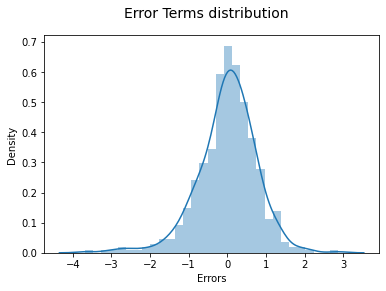

In [52]:
# Add constant to train set
X_train_lm2 = sm.add_constant(X_train_lm2)

# Predict for train set
y_train_pred = lm_final.predict(X_train_lm2)

# Plot the histogram of the error terms
fig = plt.figure()
residuals = y_train - y_train_pred
sns.distplot(residuals)
fig.suptitle('Error Terms distribution', fontsize = 14)
plt.xlabel('Errors', fontsize = 10)
plt.show()

We can see that the **errors have a normal distribution**, with median and mean centered at value zero. 

And from below graph we can see the **errors** do not follow any pattern, they **are independent of each other**.

With these information **we can rely in the significance of the model variables coefficients**.

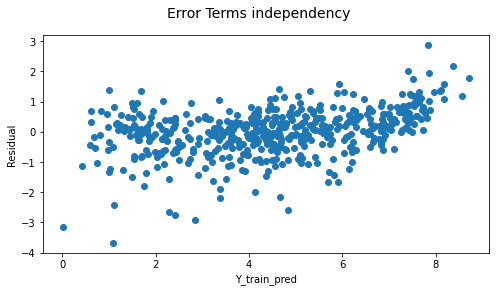

In [53]:
# Plot error terms
fig = plt.figure(figsize=(8,4))
plt.scatter(y_train,residuals)
fig.suptitle('Error Terms independency', fontsize=14)
plt.xlabel('Y_train_pred', fontsize=10)
plt.ylabel('Residual', fontsize=10) 
plt.show()

## Making predictions

It is time now to apply the model to the test set to make predictions.

Remember we already have formatted the categorical variables.

### Applying the scaling on the test sets
Let's rescale numerical variables in test set.

In [55]:
# Apply scaler() to the numerical columns
num_vars = ['temp', 'hum', 'windspeed']

df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_oct,mnth_sep,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_light_snowandrain,weathersit_mist_cloudy
184,0,1,0,0.831783,0.657364,0.084219,6.043,0,0,0,...,0,0,1,0,0,0,0,0,0,1
535,1,0,1,0.901354,0.610133,0.153728,6.211,0,1,0,...,0,0,0,0,0,0,0,1,0,0
299,0,0,1,0.511964,0.837699,0.334206,2.659,0,0,1,...,1,0,0,0,0,1,0,0,0,1
221,0,0,1,0.881625,0.437098,0.339570,4.780,0,0,0,...,0,0,0,0,0,0,0,1,0,0
152,0,0,1,0.817246,0.314298,0.537414,4.968,0,1,0,...,0,0,0,0,0,1,0,0,0,0


Now we select the final model variables from the train set. 

In [56]:
# Remove cnt column from final variables list
final_vars.remove('const')
final_vars.append('cnt')

In [57]:
# Select variables for model
df_test = df_test[final_vars]
df_test.head()

,yr,holiday,workingday,temp,windspeed,season_spring,season_summer,season_winter,mnth_jan,mnth_jul,mnth_sep,weekday_sat,weathersit_light_snowandrain,weathersit_mist_cloudy,cnt
184,0,1,0,0.831783,0.084219,0,0,0,0,1,0,0,0,1,6.043
535,1,0,1,0.901354,0.153728,0,1,0,0,0,0,0,0,0,6.211
299,0,0,1,0.511964,0.334206,0,0,1,0,0,0,0,0,1,2.659
221,0,0,1,0.881625,0.339570,0,0,0,0,0,0,0,0,0,4.780
152,0,0,1,0.817246,0.537414,0,1,0,0,0,0,0,0,0,4.968


### Predict with final model

In [58]:
# Divide in y_test and X_test
y_test = df_test.pop('cnt')
X_test = df_test

In [59]:
# Adding a constant variable 
X_test_sm = sm.add_constant(X_test)

In [60]:
# Making predictions
y_pred = lm_final.predict(X_test_sm)

## Model prediction evaluation

### R-squared and Adj. R-squared

In [61]:
# Get R-squared using SKLearn r2_score function
test_r2 = r2_score(y_test, y_pred)

# Get Adjusted R-squared (using definition formula)
# Adj. R-Squared for test dataset
sample_size = len(X_test)
vars_count = len(final_vars)
test_adj_r2 = round((1-((1-test_r2)*(sample_size-1)/(sample_size-vars_count-1))),3)

print('R-Squared: ', round(test_r2,3))
print('Adj. R-Squared: ', round(test_adj_r2,3))

R-Squared:  0.805
Adj. R-Squared:  0.79


**Most relevant summary statistics**:
- $R^{2}$ = 0.805
- Adjusted $R^{2}$ = 0.790

In prediction the $R^{2}$ and the Adjusted $R^{2}$ **values decreased but no more than 0.05**, and both values are close to each other, so we can say **the model is significant**.

### Residual analysis on the test data

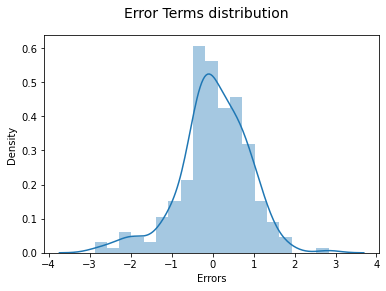

In [62]:
# Plot the histogram of the error terms
fig = plt.figure()
residuals = y_test - y_pred
sns.distplot(residuals)
fig.suptitle('Error Terms distribution', fontsize = 14)
plt.xlabel('Errors', fontsize = 10)
plt.show()

We can see that the **test set errors have a normal distribution**, with median and mean centered at value zero. 

And from below graph we can see the **errors** do not follow any pattern, they **are independent of each other**.

With these information **we can rely in the significance of the model variables coefficients**.

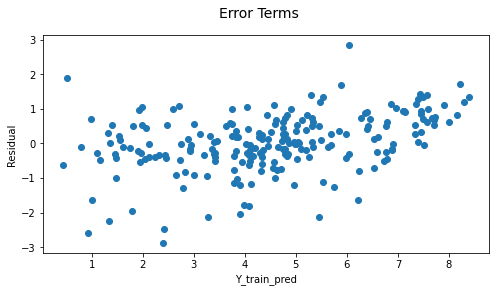

In [63]:
# Plot error terms
fig = plt.figure(figsize=(8,4))
plt.scatter(y_test,residuals)
fig.suptitle('Error Terms', fontsize=14)
plt.xlabel('Y_train_pred', fontsize=10)
plt.ylabel('Residual', fontsize=10) 
plt.show()

### Actual versus predicted values

From below plot we can see that the **final model fit isn't by chance**, and has a descent predictive power.

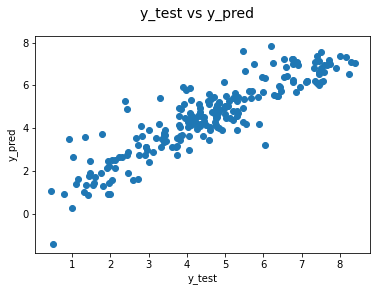

In [64]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=14)
plt.xlabel('y_test', fontsize=10)
plt.ylabel('y_pred', fontsize=10)
plt.show()

## Model summary

Final model has following statistics:
- $R^{2}$ = 0.805
- Adjusted $R^{2}$ = 0.790

Final variables and their coefficients are:

In [65]:
round(df_final_vars.sort_values('Coefficient', ascending=False),3)

,Coefficient
temp,4.110
yr,2.037
const,1.531
season_winter,0.693
mnth_sep,0.655
weekday_sat,0.508
workingday,0.404
season_summer,0.377
mnth_jan,-0.339
mnth_jul,-0.419


The **equation of our best fitted line** is:

$ cnt = 1.531 + (4.110  \times  temperature) + (2.037  \times  yr) + (0.693  \times  seasonWinter) + (0.655  \times  mnthSep) + (0.508  \times  weekdaySat) + (0.404  \times  workingday) + (0.377  \times  seasonSummer) - (0.339 \times  mnthJan) - (0.419 \times  mnthJul) - (0.488 \times  holiday) - (0.519 \times  seasonSpring) - (0.718 \times  weathersitMistCloudy) - (1.358 \times  windspeed) - (2.536  \times  weathersitLightSnowandrain) $


### Explanation of selected variables
Looking at the best fitted line equation does not give clarity of what is happening with the variables, so we'll explain in words. Remember that *our target variable has been divided by 1000* to simplify analysis.

**What does the sign of coefficient mean for a variable?** 
- A *positive coefficient* indicates that if the independent variable increases, the value of the dependent variable will increase too.
- A *negative coefficient* indicates that if the independent variable increases, the value of the dependent variable will decrease.

Note that the *correct interpretation of each coefficient* is: "change by unit in dependent variable, when all other variables are held constant".
When we talk about bikes rental increasing or decreasing when an independent variable increases or decresases, we assume all other variables are held constant.

**When all variables are zero**:

This would be a worst case scenario, but still the constant value for our equation is positive. This means that **there will be bike rentals no matter the time** (~1.531k), which is great to have!

**Positive related columns to *cnt*** are the following:
- *temp*. Bike rentals will be 4.11 greater when there are high temperatures.
- *yr*. Bike rentals will be 2.037 higher every year.
    - Bike-sharing systems are gaining popularity across time.
- *season_winter*. Bike rentals will be 0.693 higher when we are in Winter.
    - Reasons for bike rental being popular in winter might be due to different population reasons, it will depend more on the location or other transportation information (data we do not have in this study).
- *mnth_sep*. Bike rentals will be 0.655 higher when we are in September.
    - September is considered part of Summer, and from all Summer months, it is the one with less rain.
- *weekday_sat*. Bike rentals will be 0.508 higher when the day is Saturday.
    - Even if distribution of rentals is similar in all week days, Saturday was found to be significant, it is during weekend.
- *workingday*. Bike rentals will be 0.404 higher when we are in a working day.
    - We can say that people uses bikes during workingdays, might be related to transportation for work being easier with bikes to avoid traffic jams.
- *season_summer*. Bike rentals will be 0.377 higher when we are in Summer.
    - Summer has high temperatures, but why is it not more significant? Could be due to most part of summer having rain.

We can see that there is a considerable difference between the coefficients of *temp* and *yr* with the rest of the variables, so these two are the ones contributing the more to bikes rental amount.

**Negative related columns to *cnt*** are the following:
- *mnth_jan*. Bike rentals will decrease 0.339 times when we are in January.
    - January is the Winter month with most rainy and snow days.
- *mnth_jul*. Bike rentals will decrease 0.419 times when we are in July.
    - But July is part of Summer, which is positively related, why is it negative? July is the month with more rainy days.
- *holiday*. Bike rentals will decrease 0.488 times when we are in a holiday.
    - In order to confirm that people do not use bikes in holidays we'd need other transportation information, and maybe if other transports are not used, people simply would tend to stay at home those days.
- *season_spring*. Bike rentals will decrease 0.519 times when we are in Spring.
    - Spring temperatures are definitely higher than Winter, why could it not have a positive relation with bike rentals? Spring has a high percentage of windy days.
- *weathersit_mist_cloudy*. Bike rentals will decrease 0.718 times when we have Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist.
- *windspeed*. Bike rentals will decrease 1.358 times when we have high windspeed.
- *weathersit_light_snowandrain*. Bike rentals will decrease 2.536 times when we have Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds.
    - The 3 variables above are describing a bad weather to go biking, as the windspeed is high and there might be heavy rain or snow.
    
We can see that there is a considerable difference between the coefficients of *weathersit_light_snowandrain* and *windspeed* with the rest of the variables, so these two are the ones contributing the more to decreasing bikes rental amount.

## Conclusions
These are the 3 variables that contribute the most to changes in bikes rental:
- *temp* (positive)
- *yr* (positive)
- *weathersit_light_snowandrain* (negative)

When the business team is **planning the bikes supply**, they need to take in account all variables found to be significant but give most consideration the 3 variables indicated above.

The **best time to increase the supply is during the Summer, when there are high temperatures but not high windspeed or rain**.

It is also great to know that they will have bike rentals no matter the time!